In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [2]:
nielsen15 = pd.read_csv('../../Nielsen/aggregated_nielsen_2015.csv')
nielsen16 = pd.read_csv('../..//Nielsen/aggregated_nielsen_2016.csv')
nielsen15['year'] = 2015
nielsen16['year'] = 2016

In [4]:
nielsen = pd.concat((nielsen15, nielsen16))

In [5]:
## Entriy/exit dates
fandom = pd.read_csv('../data_collection/plein_de_data/fandom_traitées.csv', parse_dates=['Opening_date', 'Closing_date'])[['State', 'County_name', 'County_fips', 'Opening_date', 'Closing_date']]

# We drop the state in which we do not trust our data (some mistakes stillremain)
fandom = fandom[~np.isin(fandom.State, ('CA', 'GA', 'KS', 'LA', 'TX'))]
nielsen = nielsen[~np.isin(nielsen.store_state, ('CA', 'GA', 'KS', 'LA', 'TX'))]

# We concentrate our study on the movements (entries & exits) during the fiscal years 2015 and 2016
movements = fandom[((fandom.Opening_date >= '2014-01-31') & (fandom.Opening_date <= '2018-01-31')) | ((fandom.Closing_date >= '2014-01-31') & (fandom.Closing_date <= '2018-01-31'))]

wm = nielsen[nielsen.is_walmart].copy()
nielsen = nielsen[~nielsen.is_walmart]

In [5]:
nielsen.groupby('product_group_descr').count().sort_values('upc_price', ascending=False).head(20)

,is_walmart,store_state,guessed_store_county,guessed_store_county_fips,purchase_year,purchase_month,upc_price,upc_price_std,nb_of_obs,year
product_group_descr,,,,,,,,,,
FRESH PRODUCE,42329,42329,42329,42329,42329,42329,42329,40500,42329,42329
BREAD AND BAKED GOODS,41725,41725,41725,41725,41725,41725,41725,38980,41725,41725
MILK,40079,40079,40079,40079,40079,40079,40079,36097,40079,40079
SNACKS,39978,39978,39978,39978,39978,39978,39978,36697,39978,39978
PACKAGED MEATS-DELI,39929,39929,39929,39929,39929,39929,39929,36608,39929,39929
CHEESE,39595,39595,39595,39595,39595,39595,39595,36234,39595,39595
UNPREP MEAT/POULTRY/SEAFOOD-FRZN,39240,39240,39240,39240,39240,39240,39240,36505,39240,39240
CARBONATED BEVERAGES,37764,37764,37764,37764,37764,37764,37764,33777,37764,37764
"CONDIMENTS, GRAVIES, AND SAUCES",37701,37701,37701,37701,37701,37701,37701,33389,37701,37701


In [14]:
category = "YOGURT"

## THIRD MODEL : adding entity effects

In [15]:
# We choose to focus on fresh produce
product_group = nielsen[nielsen.product_group_descr == category]


# The control group is composed by all states where nothing (no entry nor exit) happened.
control = product_group[~np.isin(product_group.guessed_store_county_fips, movements)].copy()
print(f"Size of the control group: {len(control.guessed_store_county_fips.unique())}.")


# The treatment group is composed by the states where one entry took place in 2016 and where this entry is the only movement
count = movements.groupby('County_fips').count()
count = count[count.State==1] # No more than one movement in the treatement group
treatment_movements = movements[(np.isin(movements.County_fips, count.index))]
treatment_movements = treatment_movements[(treatment_movements.Opening_date >= '2015-01-31') & (treatment_movements.Opening_date <= '2017-01-31') & ((treatment_movements.Closing_date >= '2017-01-31')|(treatment_movements.Closing_date.apply(str) == 'NaT'))]

treatment = product_group[np.isin(product_group.guessed_store_county_fips, treatment_movements.County_fips )].copy()
treatment = treatment.merge(treatment_movements, left_on='guessed_store_county_fips', right_on='County_fips')
print(f"Size of the treatment group: {len(treatment.guessed_store_county_fips.unique())}.")


# We create our dummies for the regression
control['treat'] = False
control['interaction'] = 0
control['time_fixed_effects'] = list(zip(control.purchase_month, control.purchase_year))
control['post'] = False

treatment['treat'] = True
treatment['purchase_0'] = treatment.purchase_month * (treatment.purchase_year == 2015) + (treatment.purchase_month +12) * (treatment.purchase_year == 2016)
treatment['opening_0'] = treatment.Opening_date.dt.month * (treatment.Opening_date.dt.year == 2015) + (treatment.Opening_date.dt.month +12) * (treatment.Opening_date.dt.year == 2016)
treatment['interaction'] = treatment.purchase_0 - treatment.opening_0
treatment = treatment[abs(treatment.interaction - 5) <=12]
treatment['time_fixed_effects'] = list(zip(treatment.purchase_month, treatment.purchase_year))
treatment['post'] = treatment.purchase_0 > treatment.opening_0


# Final dataset for the regression :

df = pd.concat((control, treatment))[['upc_price', 'treat', 'interaction', 'time_fixed_effects', 'store_state', 'post']]
df = df[df.upc_price != 0]

Size of the control group: 1613.
Size of the treatment group: 65.


In [16]:
# We choose to focus on milk prices
product_groupwm = wm[wm.product_group_descr == category]

# The control group is composed by all states where nothing (no entry nor exit) happened.
controlwm = product_groupwm[~np.isin(product_groupwm.guessed_store_county_fips, movements)].copy()
print(f"Size of the control group: {len(control.guessed_store_county_fips.unique())}.")

# The treatment group is composed by the states where one entry took place in 2016 and where this entry is the only movement
count = movements.groupby('County_fips').count()
count = count[count.State==1] # No more than one movement in the treatement group
treatment_movements = movements[(np.isin(movements.County_fips, count.index))]
treatment_movements = treatment_movements[(treatment_movements.Opening_date >= '2015-01-31') & (treatment_movements.Opening_date <= '2017-01-31') & ((treatment_movements.Closing_date >= '2017-01-31')|(treatment_movements.Closing_date.apply(str) == 'NaT'))]


treatmentwm = product_groupwm[np.isin(product_groupwm.guessed_store_county_fips, treatment_movements.County_fips )].copy()
treatmentwm = treatmentwm.merge(treatment_movements, left_on='guessed_store_county_fips', right_on='County_fips')
print(f"Size of the treatment group: {len(treatmentwm.guessed_store_county_fips.unique())}.")


controlwm['treat'] = False
controlwm['interaction'] = 0
controlwm['time_fixed_effects'] = list(zip(controlwm.purchase_month, controlwm.purchase_year))

treatmentwm['treat'] = True
treatmentwm['purchase_0'] = treatmentwm.purchase_month * (treatmentwm.purchase_year == 2015) + (treatmentwm.purchase_month + 12) * (treatmentwm.purchase_year == 2016)
treatmentwm['opening_0'] = treatmentwm.Opening_date.dt.month * (treatmentwm.Opening_date.dt.year == 2015) + (treatmentwm.Opening_date.dt.month + 12) * (treatmentwm.Opening_date.dt.year == 2016)
treatmentwm['interaction'] = treatmentwm.purchase_0 - treatmentwm.opening_0
treatmentwm = treatmentwm[abs(treatmentwm.interaction - 5) <= 12]
treatmentwm['time_fixed_effects'] = list(zip(treatmentwm.purchase_month, treatmentwm.purchase_year))

dfwm = pd.concat((controlwm, treatmentwm))[['upc_price', 'treat', 'interaction', 'time_fixed_effects', 'store_state']]
dfwm = dfwm[dfwm.upc_price != 0]

Size of the control group: 1613.
Size of the treatment group: 58.


In [17]:
huhu = treatmentwm.loc[treatmentwm.index.repeat(treatmentwm.nb_of_obs)].reset_index(drop=True).drop('nb_of_obs', axis=1).groupby('interaction').mean()
hihi = treatment.loc[treatment.index.repeat(treatment.nb_of_obs)].reset_index(drop=True).drop('nb_of_obs', axis=1).groupby('interaction').mean()

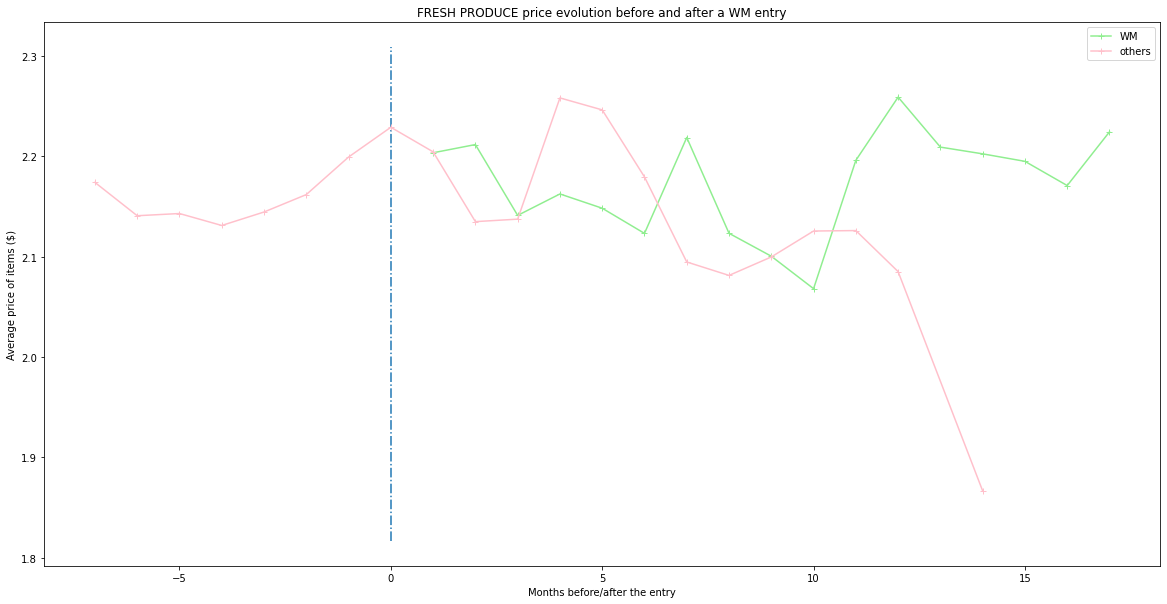

In [61]:
plt.figure(figsize=(20,10))
#plt.plot(hohowm.index, hohowm.upc_price, '-+', color='green', label='WM')
plt.plot(huhu.index, huhu.upc_price, '-+', color='lightgreen', label='WM')
#plt.plot(hoho.index, hoho.upc_price, '-+', color='red', label='others')
plt.title(f'{category} price evolution before and after a WM entry')
plt.plot(hihi.index, hihi.upc_price, '-+', color='pink', label='others')
plt.legend()
plt.xlabel('Months before/after the entry')
plt.ylabel('Average price of items ($)')
plt.vlines(0, min(hihi.upc_price.min(), huhu.upc_price.min()) - 0.05 , max(hihi.upc_price.max(), huhu.upc_price.max()) + 0.05, linestyles='-.');
#plt.savefig(f"./figs/{category}_prices.png")

Regression model :
$$

Price_{i, t}\quad = \quad\alpha \quad +\quad \beta \cdot treat_i \quad+ \quad\sum_{\tau=-7}^{17} \delta_{\tau} \cdot treat_i \cdot \mathbb{1}(t'=\tau) \quad + \quad\sum_{\tau=Feb15}^{Dec16}\gamma_{\tau} \cdot \mathbb{1}(t=\tau)\quad +\quad \sum_{s \in USStates}\gamma_{s} \cdot \mathbb{1}(state = s) \quad+\quad \varepsilon_{i, t}
$$

In [11]:
#df['post']=df.interaction>=0

In [21]:
#reg0 = smf.ols(
#   formula='np.log(upc_price) ~ treat + post + C(time_fixed_effects) + C(store_state) + C(time_fixed_effects)*C(store_state)',
#  data=df)
#results0 = reg0.fit()
#
#reg1 = smf.ols(
#    formula='np.log(upc_price) ~ treat + C(interaction) + C(time_fixed_effects)',
#   data=df)
#results1 = reg1.fit()

#reg2 = smf.ols(
#    formula='np.log(upc_price) ~ treat + C(interaction) + C(time_fixed_effects) + C(store_state) + C(time_fixed_effects)*C(store_state)',
#    data=df)
#results2 = reg2.fit()



In [49]:
#reg3 = smf.ols(
#    formula='np.log(upc_price) ~ treat + C(interaction) + C(time_fixed_effects) + C(store_state) + C(time_fixed_effects)*C(store_state)',
#    data=df)
#results3 = reg3.fit(cov_type='cluster', cov_kwds={'groups': df['store_state']})


In [50]:
#reg4 = smf.ols(
#    formula='np.log(upc_price) ~ treat + C(interaction) + C(time_fixed_effects) + C(store_state) + C(time_fixed_effects)*C(store_state)',
#    data=df)
#results4 = reg4.fit(cov_type='cluster', cov_kwds={'groups': df['time_fixed_effects']})

In [51]:
# import scipy.stats as stats

# plt.figure(figsize=(20, 10))
# plt.title(f'Effect of WM entry on {category} prices')
# plt.xlabel('Months before/after the entry')

# coefs3 = np.exp(results3.params[2:16]) - 1
# cv_t = stats.t.ppf(1 - 0.005, len(df) - len(coefs3) - 2)
# lower_CI_5_3 = coefs3 - cv_t * results3.bse[2:16]
# upper_CI_5_3 = coefs3 + cv_t * results3.bse[2:16]
# plt.plot(range(-6, 8), coefs3, color='blue', label='use_correction')
# plt.plot(range(-6, 8), lower_CI_5_3, color='lightblue', linestyle='--', label='confidence interval, 95%')
# plt.plot(range(-6, 8), upper_CI_5_3, color='lightblue', linestyle='--')


# coefs4 = np.exp(results4.params[2:16]) - 1
# cv_t = stats.t.ppf(1 - 0.005, len(df) - len(coefs4) - 2)
# lower_CI_5_4 = coefs4 - cv_t * results4.bse[2:16]
# upper_CI_5_4 = coefs4 + cv_t * results4.bse[2:16]
# plt.plot(range(-6, 8), coefs4, color='pink', label='df_correction')
# plt.plot(range(-6, 8), lower_CI_5_4, color='pink', label='confidence interval, 95%')
# plt.plot(range(-6, 8), upper_CI_5_4, color='pink')

# coefs5 = np.exp(results5.params[2:16]) - 1
# cv_t = stats.t.ppf(1 - 0.005, len(df) - len(coefs5) - 2)
# lower_CI_5_5 = coefs5 - cv_t * results5.bse[2:16]
# upper_CI_5_5 = coefs5 + cv_t * results5.bse[2:16]
# plt.plot(range(-6, 8), coefs5, color='darkblue', label='ø' )
# plt.plot(range(-6, 8), lower_CI_5_5, color='darkblue', label='confidence interval, 95%')
# plt.plot(range(-6, 8), upper_CI_5_5, color='darkblue')


# plt.plot([-7, 7], [0, 0], linestyle='--', color='lightgrey')
# plt.vlines(0, -0.5, 0.5, color='red', label='WM entry')
# plt.legend();
# #plt.savefig(f"./figs/{category}regression.png")

In [37]:
notwm_reg = smf.ols(
    formula='np.log(upc_price) ~ treat + C(interaction) + C(time_fixed_effects) + C(store_state) + C(time_fixed_effects)*C(store_state)',
    data=df)
notwm_results = notwm_reg.fit(cov_type='cluster', cov_kwds={'groups': df['store_state']})


In [38]:
wm_reg = smf.ols(
    formula='np.log(upc_price) ~ treat + C(interaction) + C(time_fixed_effects) + C(store_state) + C(time_fixed_effects)*C(store_state)',
    data=dfwm)
wm_results = wm_reg.fit(cov_type='cluster', cov_kwds={'groups': dfwm['store_state']})

In [54]:
# import scipy.stats as stats

# plt.figure(figsize=(20, 10))
# plt.title(f'Effect of WM entry on {category} prices')
# plt.xlabel('Months before/after the entry')


# # NOT WALMART
# start_price = hihi.upc_price[-7]

# coefs = np.exp(notwm_results.params[2:16]) - 1
# cv_t = stats.t.ppf(1 - 0.005, len(df) - len(coefs) - 2)
# lower_CI_5 = coefs - cv_t * notwm_results.bse[2:16]
# upper_CI_5 = coefs + cv_t * notwm_results.bse[2:16]

# prices_minus = [start_price]
# prices = [start_price]
# prices_plus = [start_price]
# for i in range(14):
#     prices_minus.append(prices[0] * (1 + lower_CI_5[i]))
#     prices.append(prices[0] * (1 + coefs[i]))
#     prices_plus.append(prices[0] * (1 + upper_CI_5[i]))

# plt.plot(range(-7, 8), prices, '-+', color='blue', label='not-WM : price after control (regression results)')
# plt.plot(range(-7, 8), prices_minus, color='navy', linestyle='--', label='confidence interval, 95%')
# plt.plot(range(-7, 8), prices_plus, color='navy', linestyle='--')

# plt.plot(hihi.index, hihi.upc_price, '-+', color='cornflowerblue', label='not-WM : rough price (no correction)')



# # WALMART
# start_pricewm = huhu.upc_price[-7]

# coefswm = np.exp(wm_results.params[2:16]) - 1
# cv_twm = stats.t.ppf(1 - 0.005, len(dfwm) - len(coefswm) - 2)
# lower_CI_5_wm = coefswm - cv_twm * wm_results.bse[2:16]
# upper_CI_5_wm = coefswm + cv_twm * wm_results.bse[2:16]

# prices_minuswm = [start_pricewm]
# priceswm = [start_pricewm]
# prices_pluswm = [start_pricewm]
# for i in range(14):
#     prices_minuswm.append(priceswm[0] * (1 + lower_CI_5_wm[i]))
#     priceswm.append(priceswm[0] * (1 + coefswm[i]))
#     prices_pluswm.append(priceswm[0] * (1 + upper_CI_5_wm[i]))

# plt.plot(range(-7, 8), priceswm, '-+', color='limegreen', label='WM : price after control (regression results)')
# plt.plot(range(-7, 8), prices_minuswm, color='darkgreen', linestyle='--', label='confidence interval, 95%')
# plt.plot(range(-7, 8), prices_pluswm, color='darkgreen', linestyle='--')

# plt.plot(huhu.index, huhu.upc_price, '-+', color='mediumspringgreen', label='WM : rough price (no correction)')



# plt.plot([-7, 7], [start_price, start_price], linestyle='--', color='lightgrey')
# plt.vlines(0, 1.8, 2.3, color='red', label='WM entry')
# plt.legend();

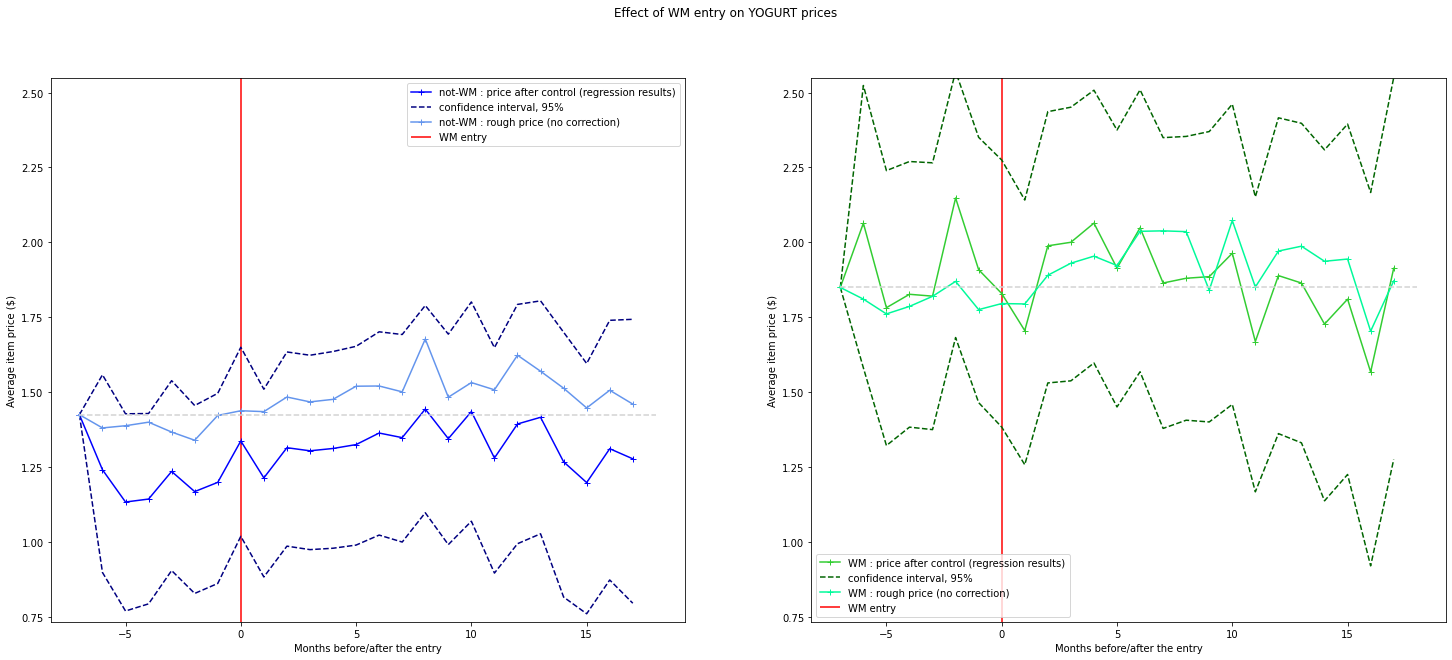

In [39]:
import scipy.stats as stats

fig, ax = plt.subplots(1, 2, figsize=(25, 10))
fig.suptitle(f'Effect of WM entry on {category} prices')


# NOT WALMART
start_price = hihi.upc_price[-7]

coefs = np.exp(notwm_results.params[2:26]) - 1
cv_t = stats.t.ppf(1 - 0.005, len(df) - len(coefs) - 2)
lower_CI_5 = notwm_results.conf_int(alpha=0.05)[0][2:26]
upper_CI_5 = notwm_results.conf_int(alpha=0.05)[1][2:26]

prices_minus = [start_price]
prices = [start_price]
prices_plus = [start_price]
for i in range(24):
    prices_minus.append(prices[0] * (1 + lower_CI_5.iloc[i]))
    prices.append(prices[0] * (1 + coefs[i]))
    prices_plus.append(prices[0] * (1 + upper_CI_5.iloc[i]))

ax[0].set_xlabel('Months before/after the entry')
ax[0].set_ylabel('Average item price ($)')
ax[0].plot(range(-7, 18), prices, '-+', color='blue', label='not-WM : price after control (regression results)')
ax[0].plot(range(-7, 18), prices_minus, color='navy', linestyle='--', label='confidence interval, 95%')
ax[0].plot(range(-7, 18), prices_plus, color='navy', linestyle='--')
ax[0].plot(hihi.index, hihi.upc_price, '-+', color='cornflowerblue', label='not-WM : rough price (no correction)')



# WALMART
start_pricewm = huhu.upc_price[-7]

coefswm = np.exp(wm_results.params[2:26]) - 1
cv_twm = stats.t.ppf(1 - 0.005, len(dfwm) - len(coefswm) - 2)
lower_CI_5_wm = wm_results.conf_int(alpha=0.05)[0][2:26]
upper_CI_5_wm = wm_results.conf_int(alpha=0.05)[1][2:26]

prices_minuswm = [start_pricewm]
priceswm = [start_pricewm]
prices_pluswm = [start_pricewm]
for i in range(24):
    prices_minuswm.append(priceswm[0] * (1 + lower_CI_5_wm.iloc[i]))
    priceswm.append(priceswm[0] * (1 + coefswm[i]))
    prices_pluswm.append(priceswm[0] * (1 + upper_CI_5_wm.iloc[i]))

ax[1].set_xlabel('Months before/after the entry')
ax[1].set_ylabel('Average item price ($)')
ax[1].plot(range(-7, 18), priceswm, '-+', color='limegreen', label='WM : price after control (regression results)')
ax[1].plot(range(-7, 18), prices_minuswm, color='darkgreen', linestyle='--', label='confidence interval, 95%')
ax[1].plot(range(-7, 18), prices_pluswm, color='darkgreen', linestyle='--')
ax[1].plot(huhu.index, huhu.upc_price, '-+', color='mediumspringgreen', label='WM : rough price (no correction)')


a = min(np.array(priceswm).min(), np.array(prices).min()) - 0.4
b = max(np.array(priceswm).max(), np.array(prices).max()) + 0.4

ax[0].plot([-7, 18], [start_price, start_price], linestyle='--', color='lightgrey')
ax[0].vlines(0, a , b, color='red', label='WM entry')
ax[1].plot([-7, 18], [start_pricewm, start_pricewm], linestyle='--', color='lightgrey')
ax[1].vlines(0, a, b, color='red', label='WM entry')
ax[0].set_ylim((a, b))
ax[1].set_ylim((a, b))
ax[0].legend()
ax[1].legend();